# Forecasting temperature with SARIMA


## Introduction

> Temperature forecasting is a challenging but important task. The areas in need of accurate forecasting are many, ranging from agriculture to energy consumption. An increase in air temperature would also lead to sea-level rise, global warming and will negatively impact humans. 

> In this notebook, air temperature in Stockholm was modeled by Seasonal Autoregressive Moving Average (SARIMA).


https://irjabs.com/files_site/paperlist/r_449_121110152548.pdf

http://www.statistics.du.se/essays/D09_Xier_Li.pdf

http://www.statistics.du.se/essays/D08D_XiangJunquan.pdf

In [36]:
library(plotly);
library(ggplot2);
library(ggfortify);
library(repr);
library(tidyr);
library(tsibble);
library(TSstudio);
library(zoo);
library(dplyr);
library(tseries)
library(forecast);

library(ggridges)
library(viridis)
library(hrbrthemes)
library(heatmaply)

Sys.setlocale(locale = "English");
windowsFonts(Times=windowsFont("Times New Roman"));

options(repr.plot.width=14, repr.plot.height=8)
IRdisplay::display_html('<style>.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}</style>')

th <- theme(text=element_text(size = 20, face = "bold",  family="Times"),
        plot.title = element_text(size = 25, face = "bold",  family="Times", hjust = 0.5),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid = element_line(size = 0.25, linetype = 'solid',
                                colour = "grey80"))

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

https://bolin.su.se/data/stockholm-historical-monthly-temperature-3?n=stockholm-historical-temps-monthly-3

## Models

The autoregressive moving-average (ARMA) process is an fundamental parametric family of stationary time series. If selected time series (i) does not exhibit evidence against stationarity and (ii) rapidly decreasing autocovariance function, an ARMA could potentially be fitted to the mean-corrected data. Otherwise, considering autoregressive integrated moving-average (ARIMA) can prove to be wise. For a time series {$X_t$}, SARIMA is defined as

$$
\phi(B)(1-B)^d X_t = \theta(B)Z_t, \quad {Z_t} \sim WN(0, \sigma^2)
$$
where $\phi(z)$ and $\theta(z)$ are a

If the time series has an apparent seasonal component, seasonal ARIMA (SARIMA) becomes a valid option. 

Finding an appropriate model for non-stationary time series require the use of autoregressive integrated moving-average (ARIMA). 

## Data source
The data consist out of 36 years of monthly mean air temperatures. 

In [37]:
train_df <- read.csv("dataset/train_stockholm_monthly_mean_temperature.csv", sep=';')
test_df <- read.csv("dataset/test_stockholm_monthly_mean_temperature.csv", sep=';')
df <- rbind(train_df, test_df)
head(df)

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,-4.7,-6.2,-3.1,4.8,7.8,15.6,16.8,14.6,12.8,5.7,0.0,-0.8
2,1981,-4.0,-2.7,-2.2,3.9,10.8,12.6,16.4,14.6,11.7,6.5,1.1,-5.7
3,1982,-7.2,-4.0,1.1,4.1,9.4,12.5,17.4,17.0,12.3,7.6,4.5,0.3
4,1983,0.7,-3.8,-0.1,4.0,10.2,14.0,18.0,17.8,12.4,7.5,1.2,-1.1
5,1984,-3.0,-1.7,-2.0,5.3,10.9,13.3,15.3,16.4,10.6,8.9,4.3,0.8
6,1985,-9.0,-11.6,-1.7,1.6,9.0,13.6,15.9,15.4,10.3,8.0,0.3,-4.3


In [59]:
train <- ts(as.vector(t(as.matrix(train_df[,-1]))), start=c(min(train_df$year), 1), 
            end=c(max(train_df$year), 12), frequency =12)

df_ts <- ts(as.vector(t(as.matrix(df[,-1]))), start=c(1980, 1), 
            end=c(2020, 12), frequency =12)

# Reshaped version for visualization
train_reshape <- data.frame(date=as.Date(as.yearmon(time(train))), temp=as.matrix(train))
train_reshape$month <- format(train_reshape$date, "%b")
train_reshape$year <- format(train_reshape$date, "%Y")

head(train_reshape)

,date,temp,month,year
,<date>,<dbl>,<chr>,<chr>
1,1980-01-01,-4.7,Jan,1980
2,1980-02-01,-6.2,Feb,1980
3,1980-03-01,-3.1,Mar,1980
4,1980-04-01,4.8,Apr,1980
5,1980-05-01,7.8,May,1980
6,1980-06-01,15.6,Jun,1980


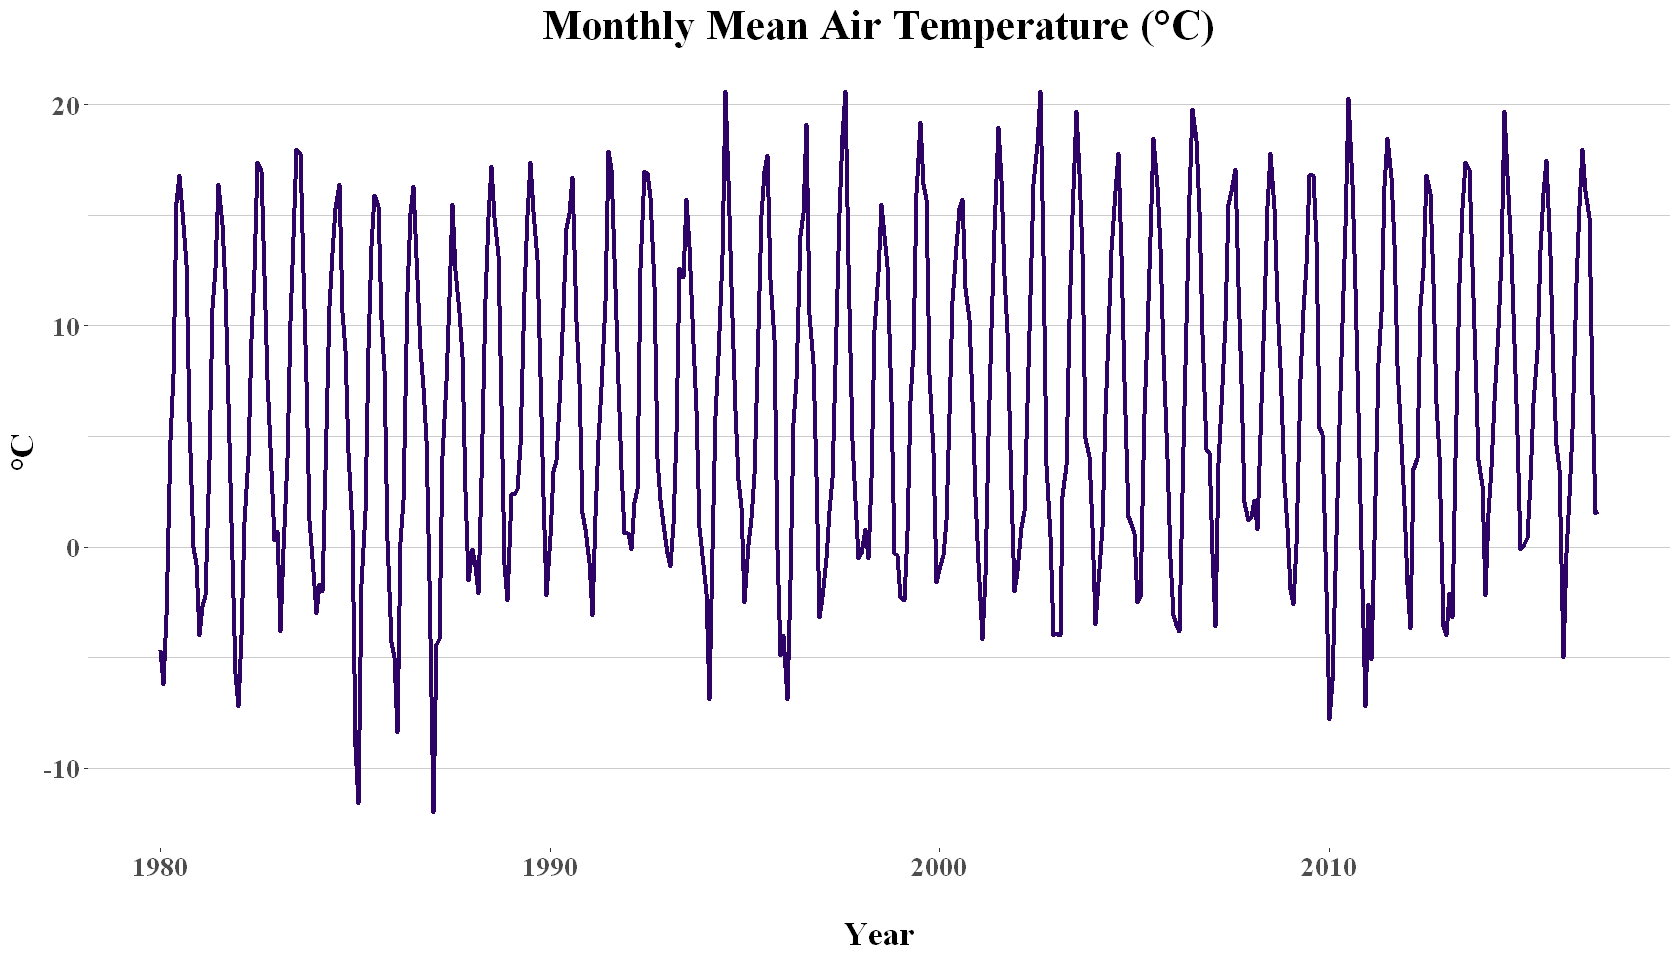

In [39]:
ggplot(data=train_reshape, aes(x=date, y=temp, group=1))+
    ggtitle("Monthly Mean Air Temperature (°C)")+
    geom_line(color="#2d0365", size=1.2)+
    xlab("\nYear") + ylab("°C") +
    th + theme(legend.position="none")

> Ridgeline plot. Potential outliers in January and February. 

Picking joint bandwidth of 0.787



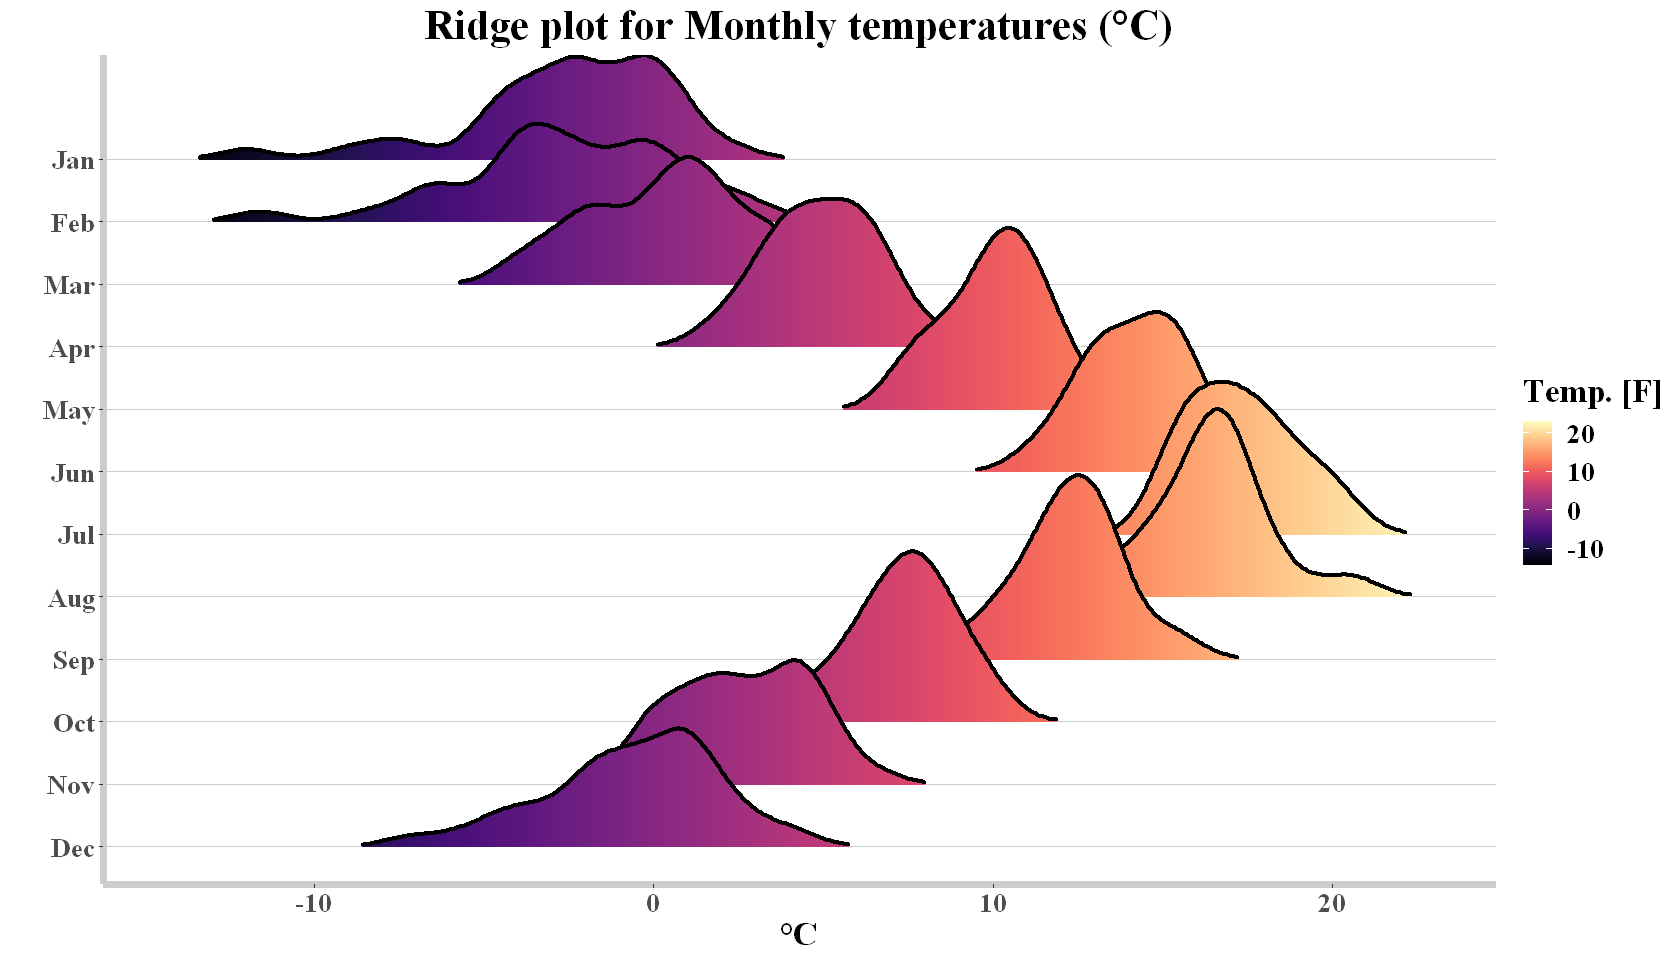

In [40]:
ggplot(train_reshape, aes(x = temp, y = factor(month, levels = month.abb), fill = ..x..))+
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01, lwd=1.2) +
    scale_fill_viridis(name = "Temp. [F]", option = "A") +
    labs(title = 'Ridge plot for Monthly temperatures (°C)') +
    scale_y_discrete(limits=rev) +
    xlab("°C") + ylab("") +
    th + theme(axis.line = element_line(size = 2, colour = "grey80"))

Outliers are better visualised through a boxplot. From both the ridge plot and boxplot, it appears is if the variance is not consistent over months.

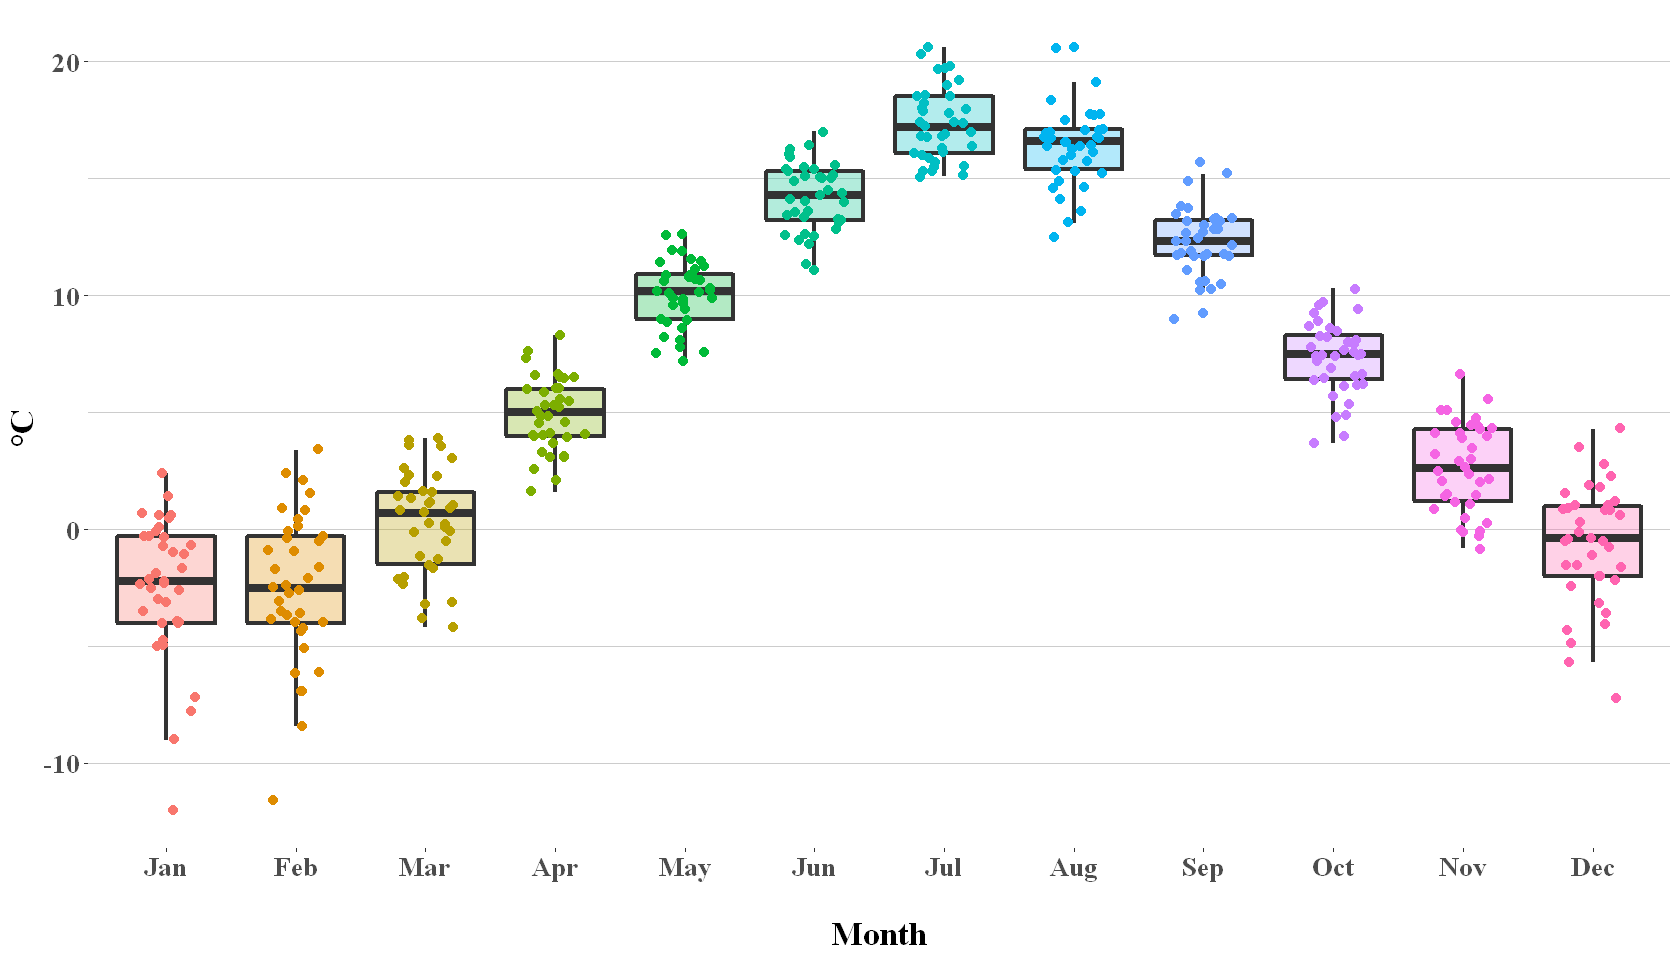

In [57]:
ggplot(train_reshape, aes(x = factor(month, levels = month.abb), y = temp, fill=factor(month, levels = month.abb)))+
    geom_boxplot(outlier.alpha = 0, alpha=0.3, lwd=1.2) +
    geom_jitter(size=2.4, position=position_jitter(0.23), aes(colour=factor(month, levels = month.abb)))+ 
    xlab("\nMonth") + ylab("°C") +
    th + theme(legend.position="none")

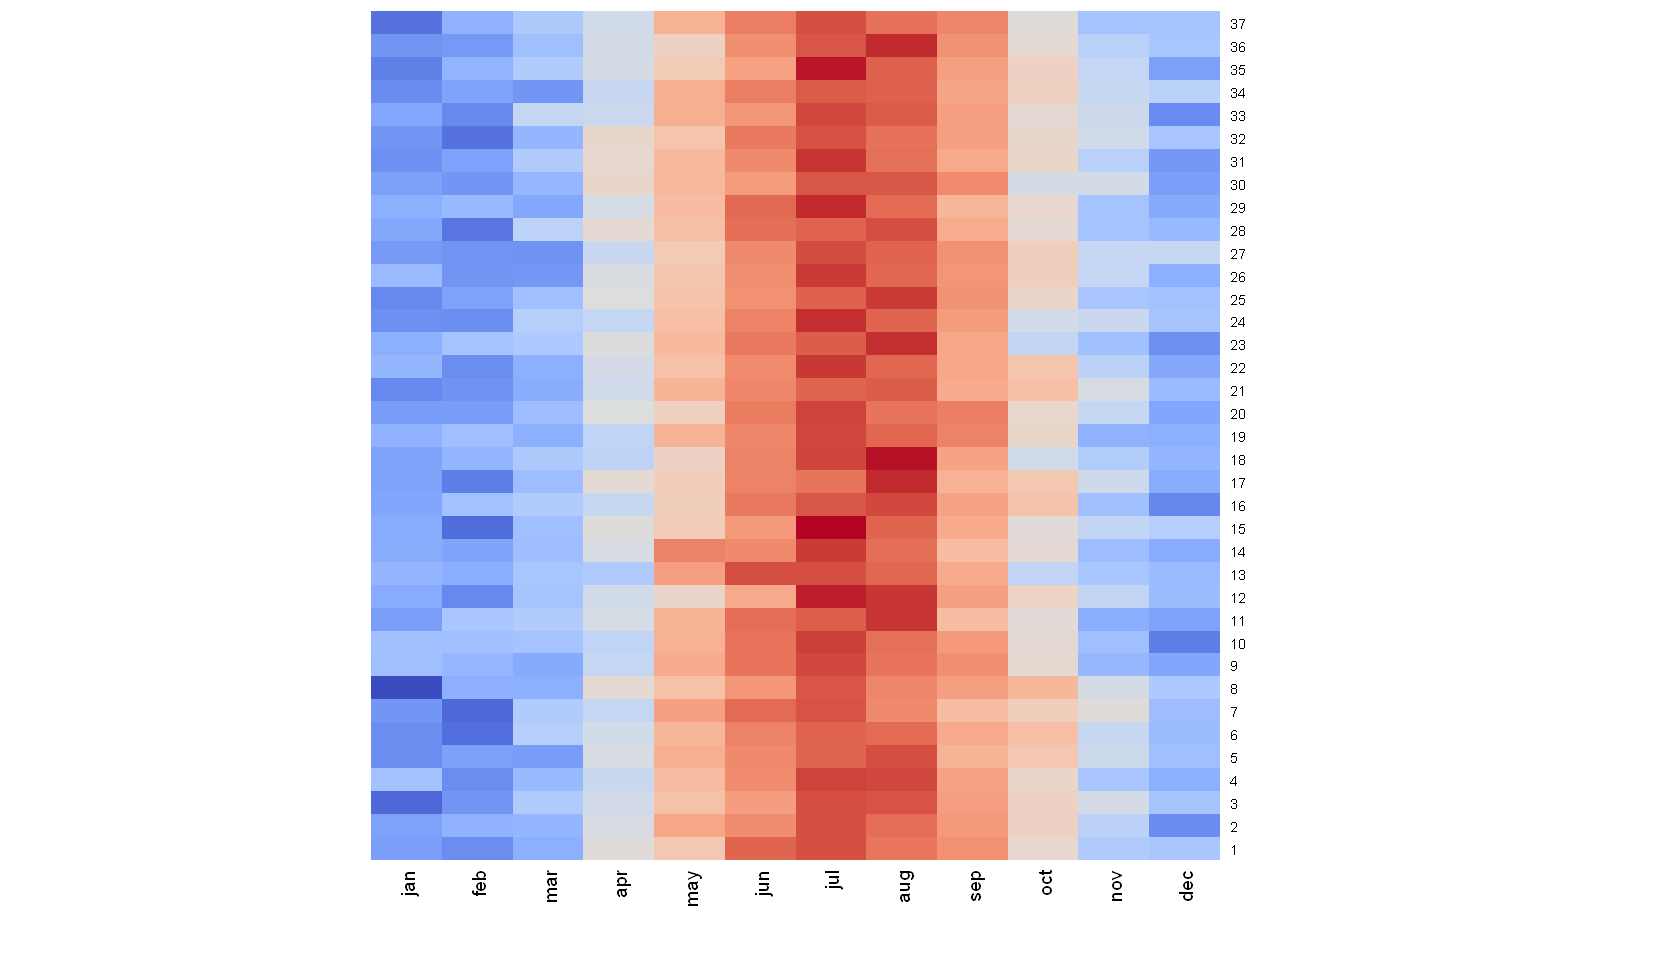

In [42]:
dt <- as.matrix(train_df[,-1])
heatmap(dt, Colv =NA, Rowv =NA, col=cool_warm(256))

For example, a root near 1 of the autoregressive polynomial suggests that the data
should be differenced before fitting an ARMA model, whereas a root near 1 of
the moving-average polynomial indicates that the data were overdifferenced.

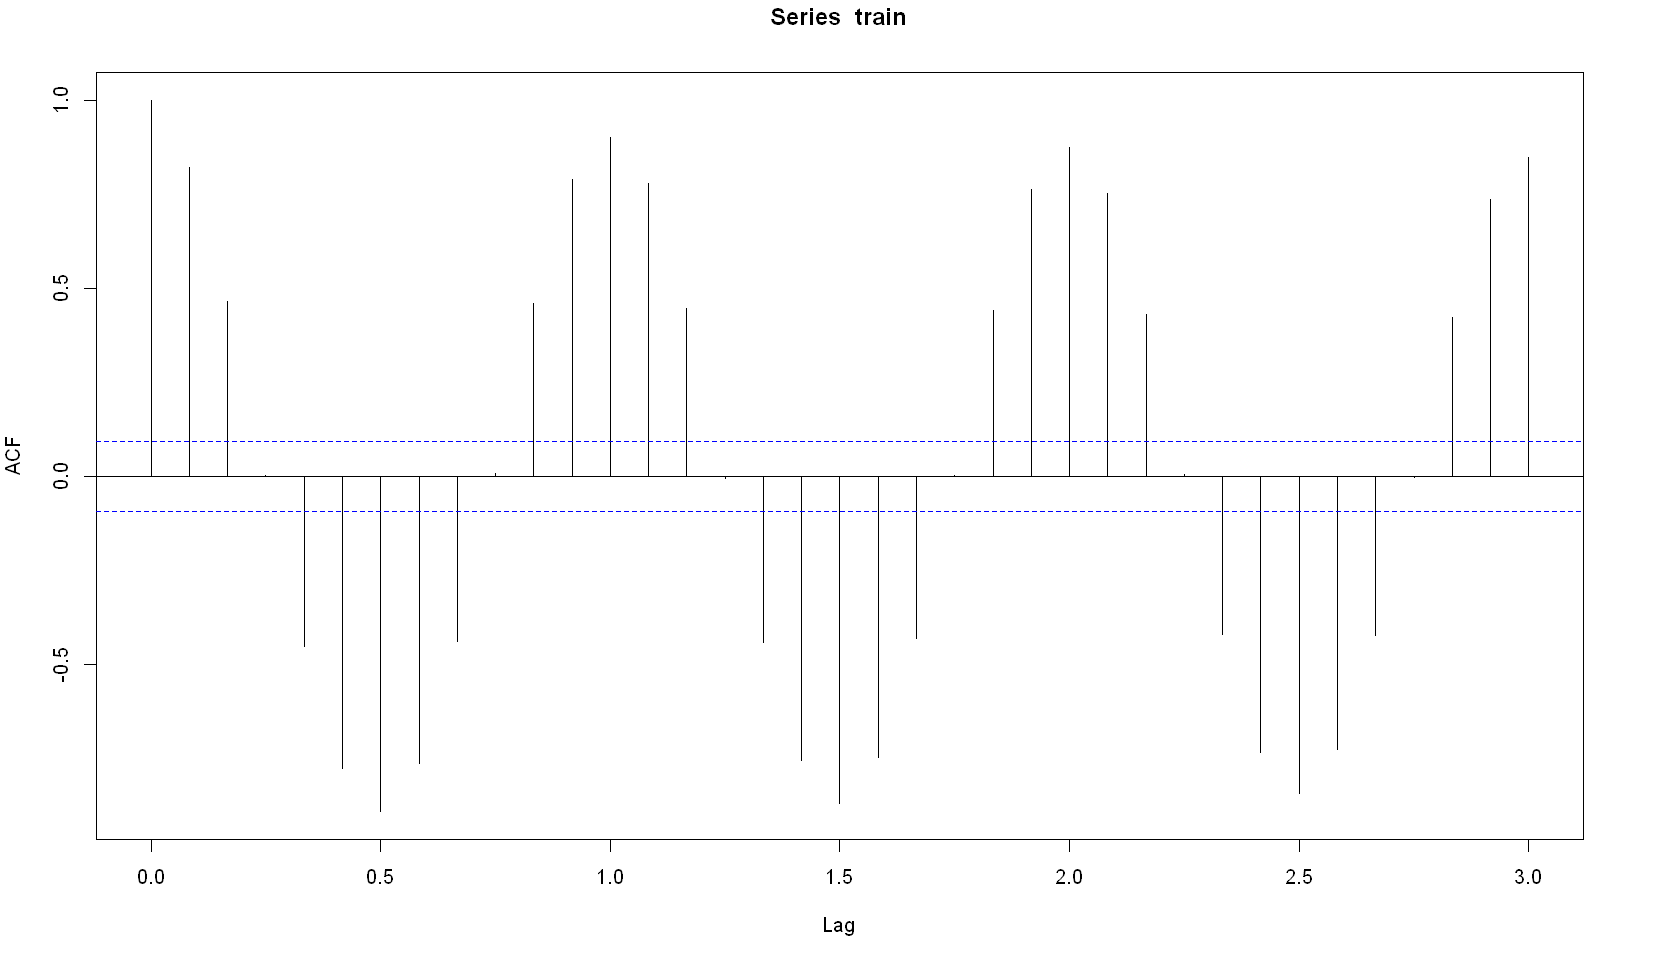

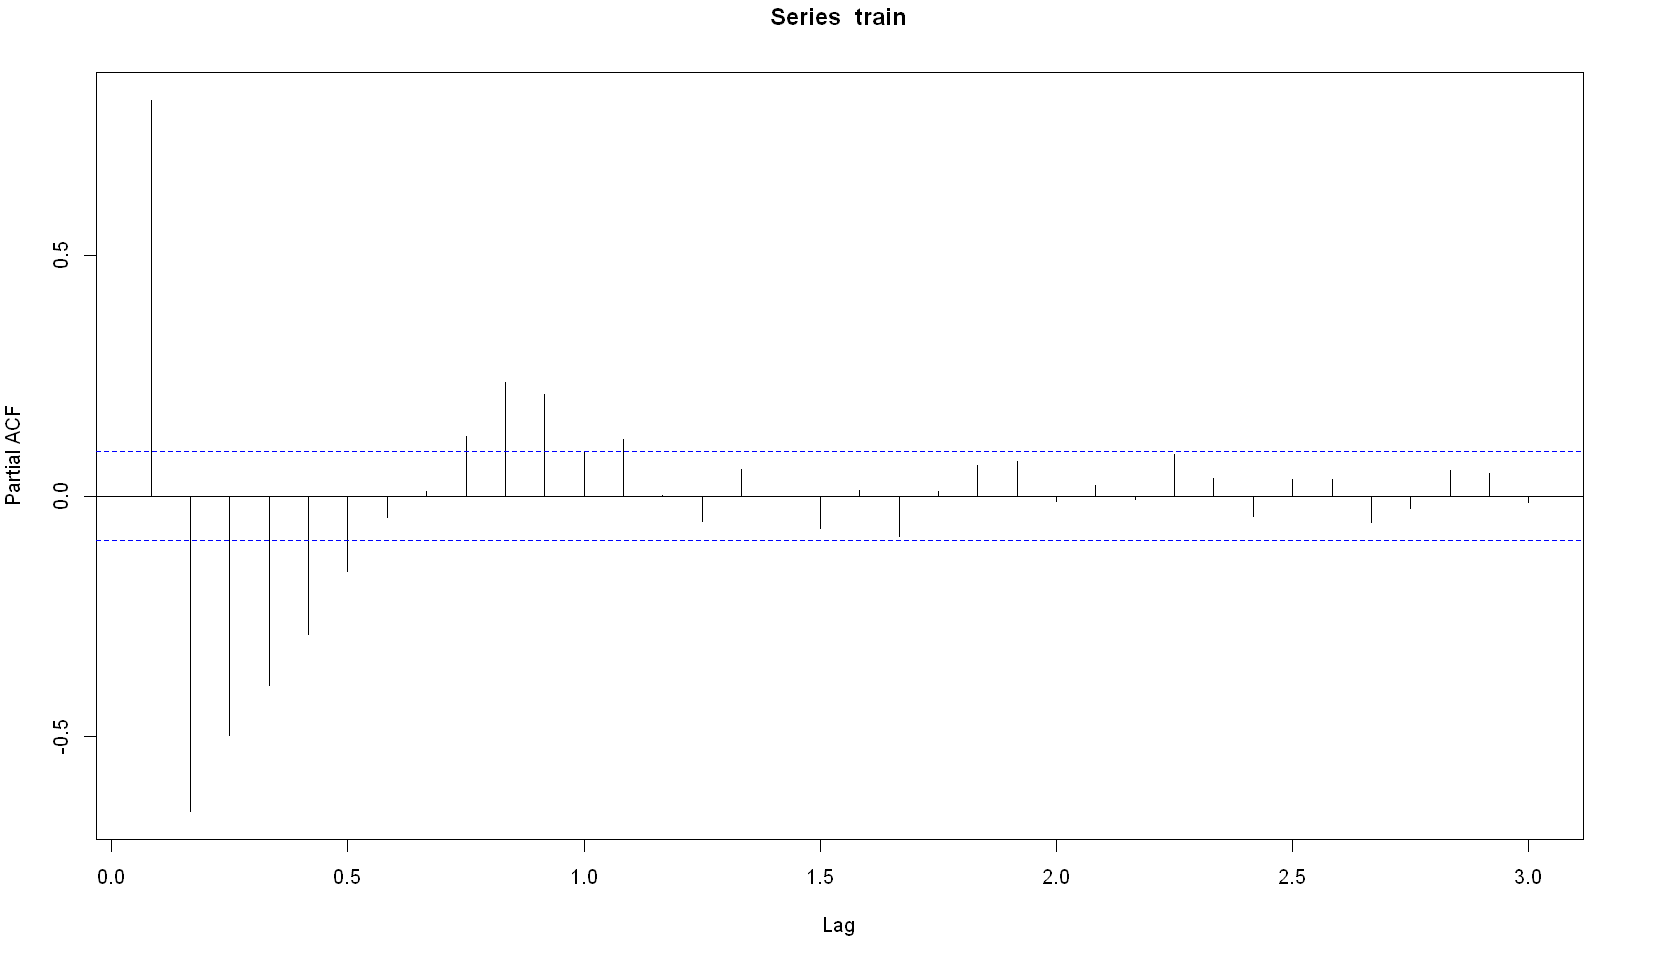

In [43]:
par(mar=c(5,4,3,4))
acf(train, lag.max = 36)
pacf(train, lag.max = 36)

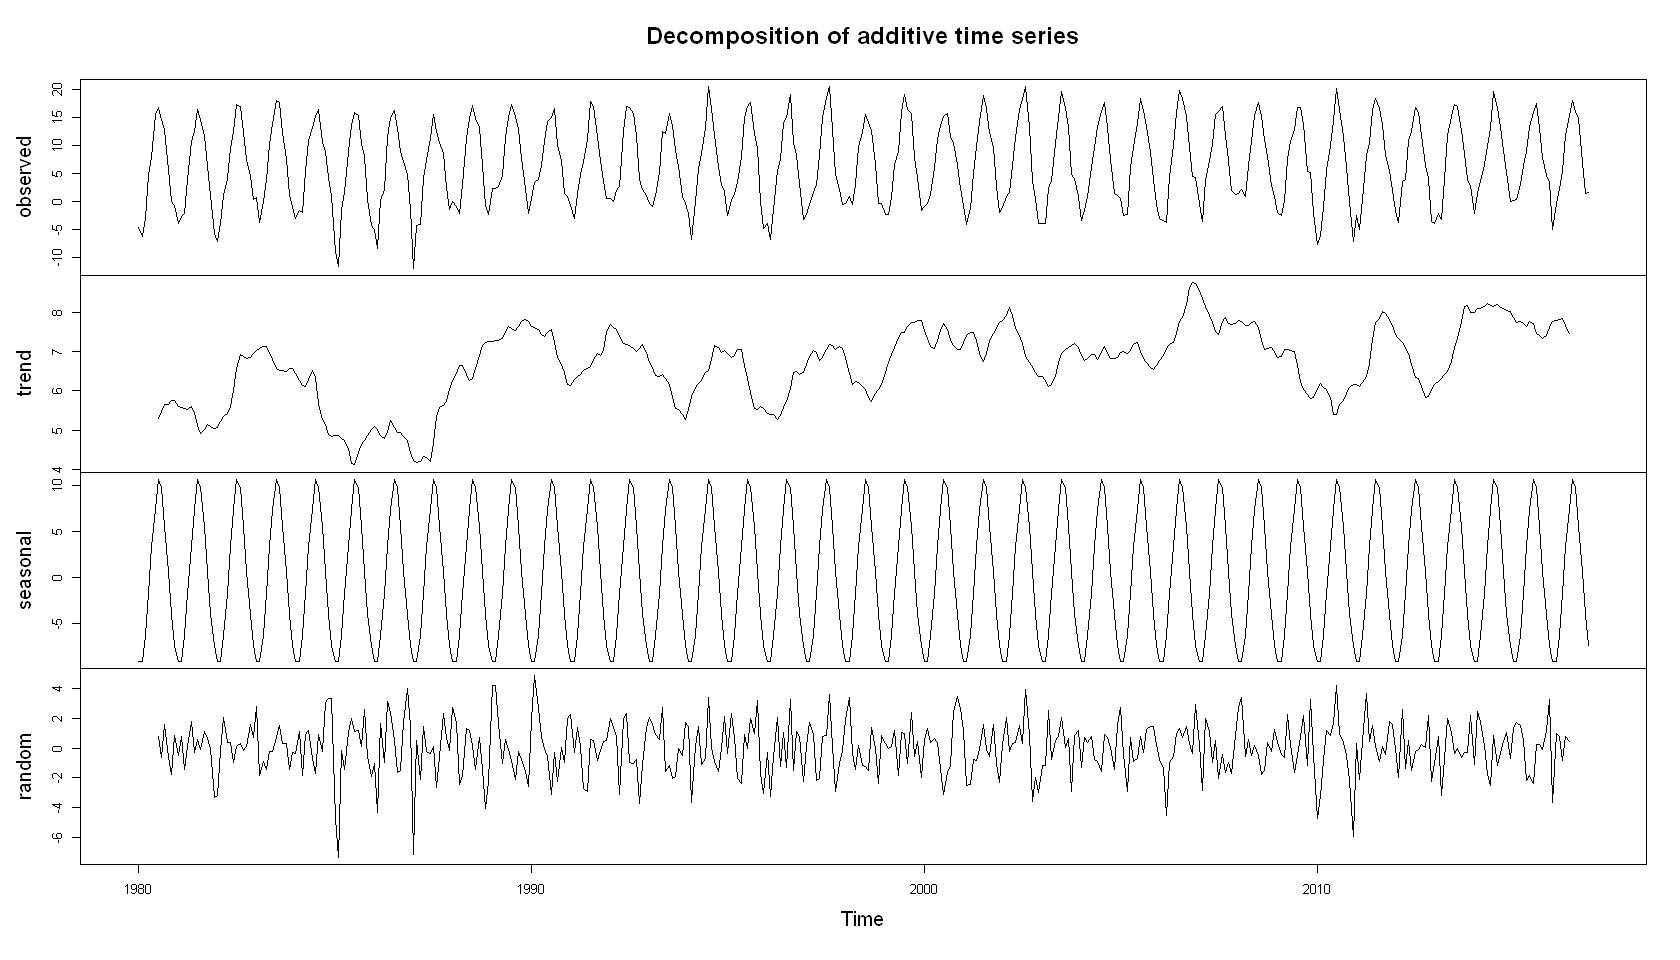

In [44]:
decomp = decompose(train)
plot(decomp)

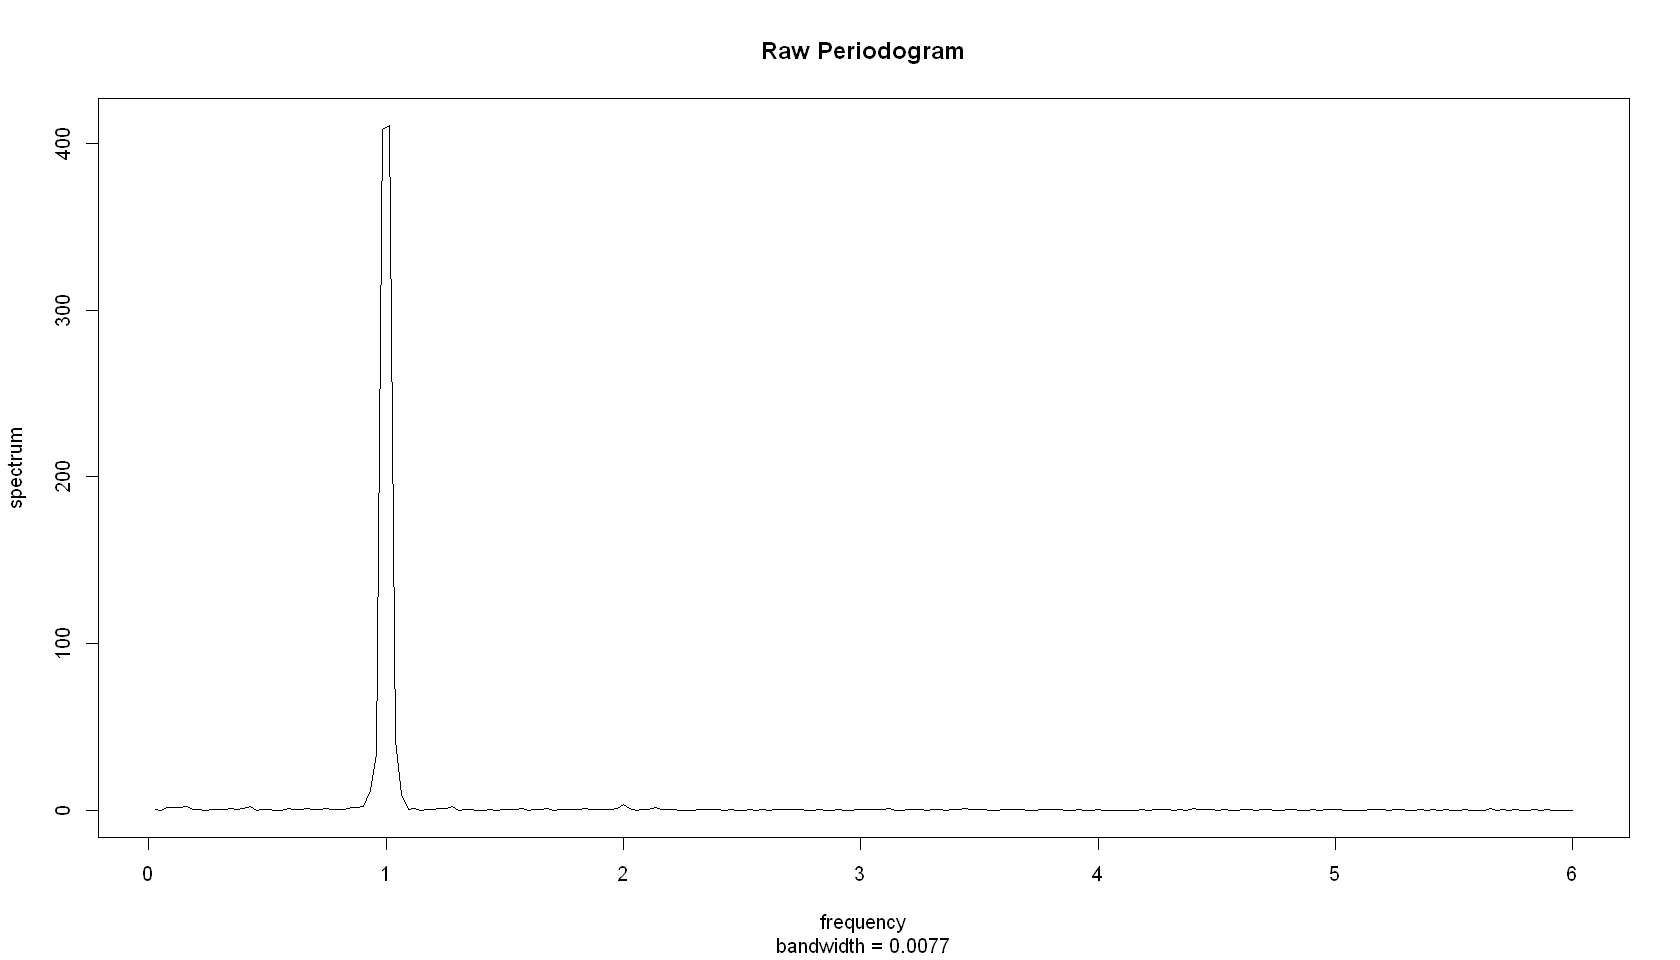

In [45]:
spec.pgram(train, log="no", main="Raw Periodogram")

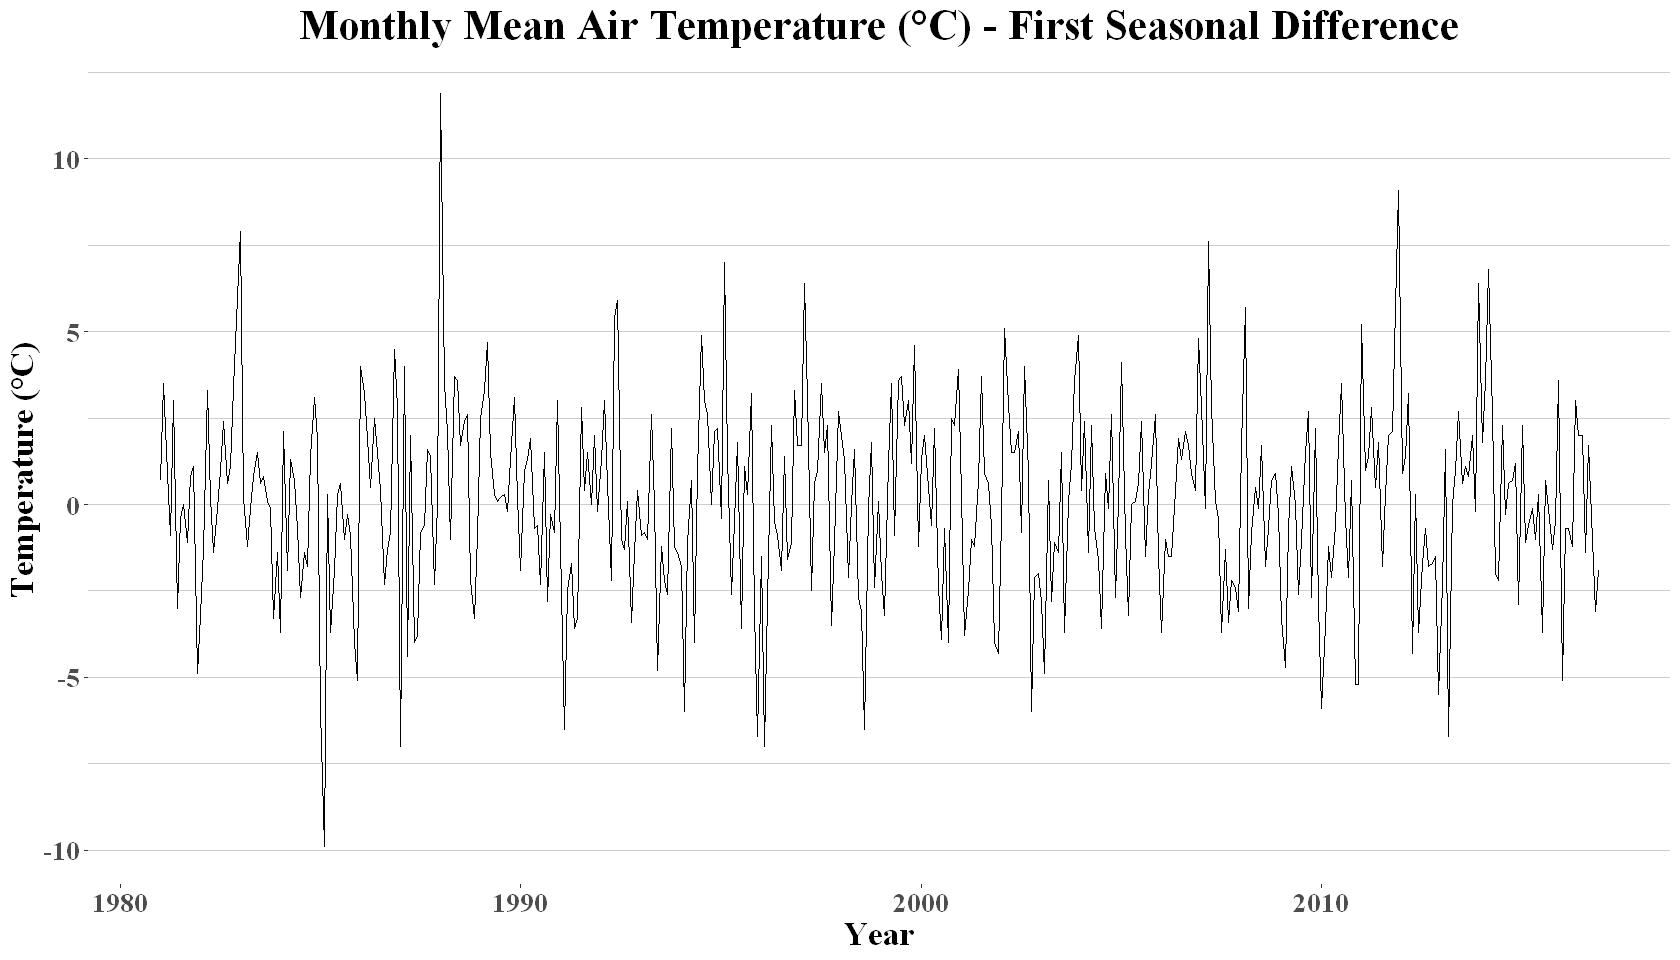

In [46]:
# Seasonal difference
train.diff = diff(train, lag=12)

autoplot(train.diff, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C) - First Seasonal Difference")+ 
    th + 
    guides(colour = guide_legend(title.hjust = 20))

In [47]:
adf.test(train.diff)

Warning message in adf.test(train.diff):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train.diff
Dickey-Fuller = -6.5205, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [48]:
kpss.test(train.diff)

Warning message in kpss.test(train.diff):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  train.diff
KPSS Level = 0.021325, Truncation lag parameter = 5, p-value = 0.1


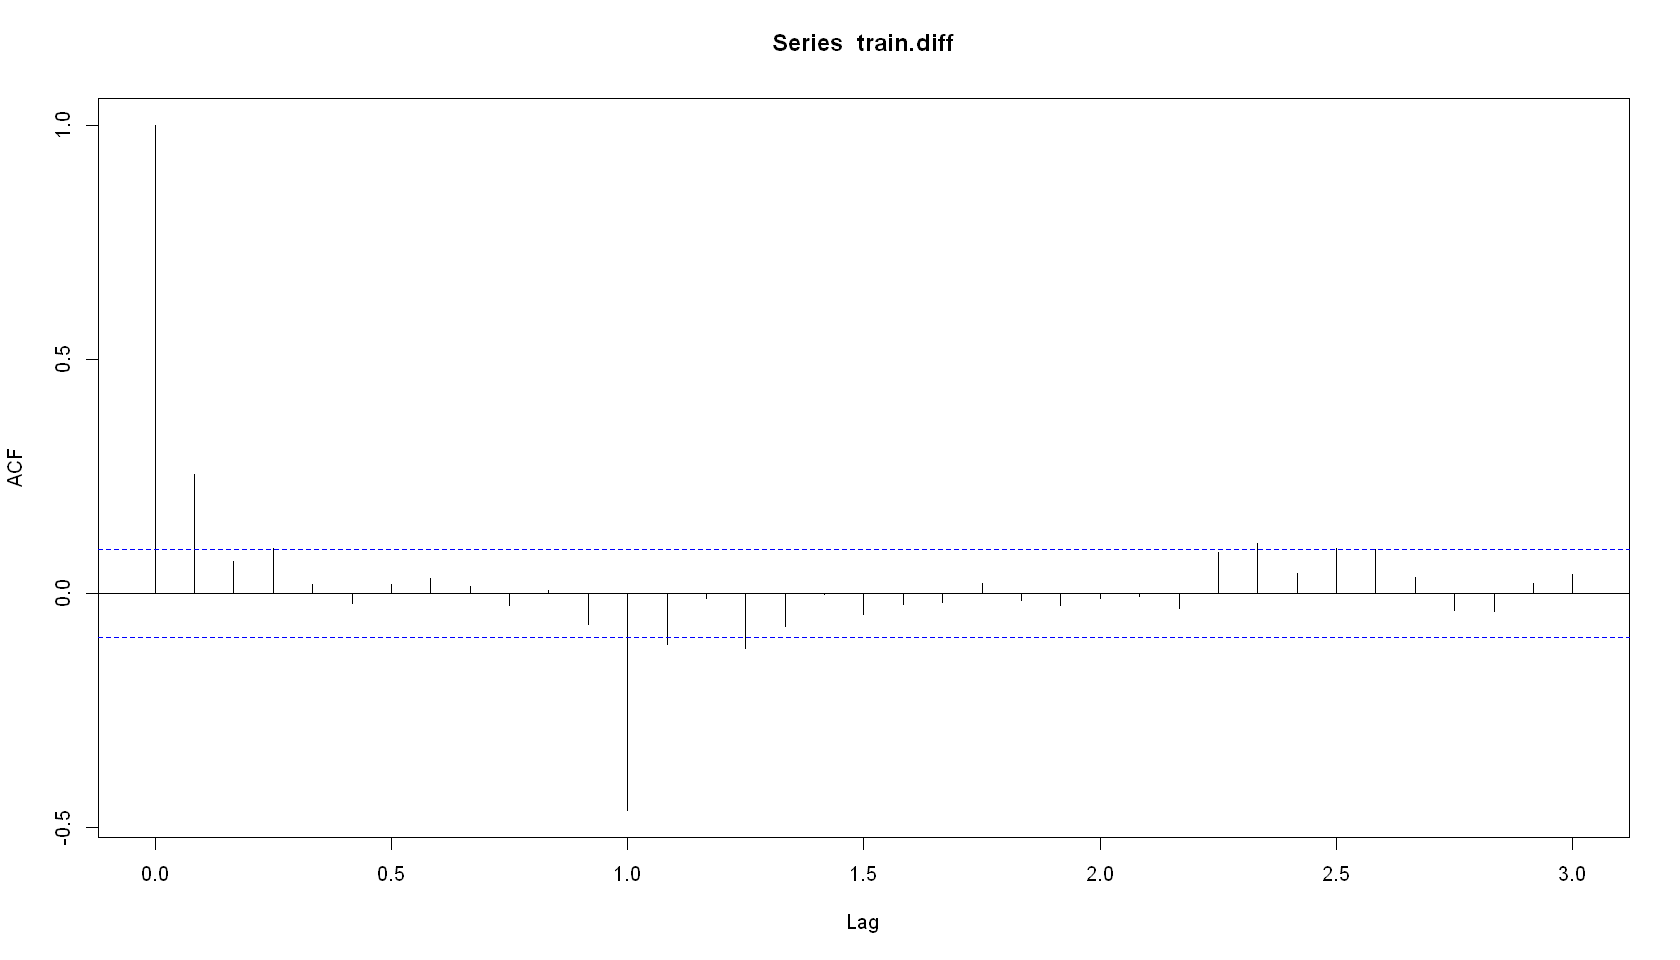

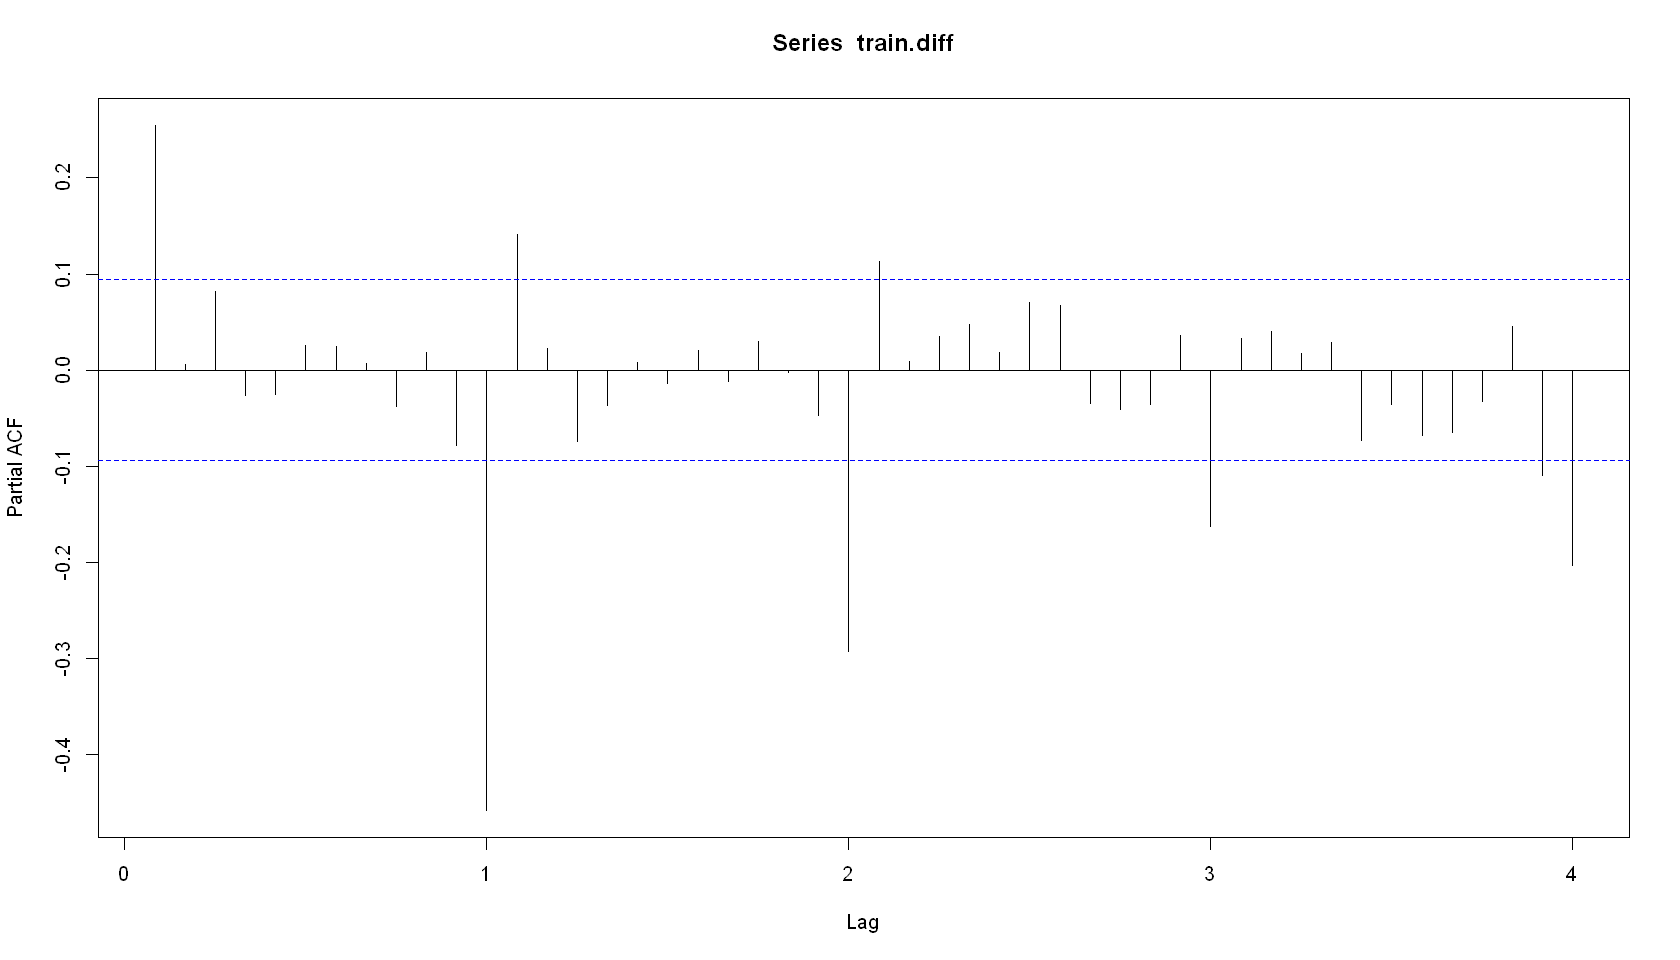

In [49]:
acf(train.diff, lag.max=36)
pacf(train.diff, lag.max=48)

In [50]:
p <- q <- P <- Q <- 0:3
grid <- expand.grid(p=p, q=q, P=P, Q=Q)
grid$k <- rowSums(grid)
grid <- grid %>% filter(k<=4)

arima_search <- lapply(1:nrow(grid), function(i){
    mdl <- NULL
    mdl <- try(arima(train, order=c(grid$p[i], 0, grid$q[i]), 
                     seasonal=list(order=c(grid$P[i], 1, grid$Q[i]), period=12)))
    
    aic_scores <- data.frame(p = grid$p[i], d=0, q=grid$q[i], P=grid$P[i], D=1, Q=grid$Q[i], AIC = mdl$aic)
}) %>% bind_rows() %>% arrange(AIC)

head(arima_search)

Warning message in arima(train, order = c(grid$p[i], 0, grid$q[i]), seasonal = list(order = c(grid$P[i], :
"possible convergence problem: optim gave code = 1"


,p,d,q,P,D,Q,AIC
,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,2,0,1,0,1,1,1828.821
2,1,0,2,0,1,1,1832.071
3,1,0,0,0,1,1,1834.952
4,1,0,0,1,1,2,1835.330
5,1,0,1,0,1,1,1836.200
6,2,0,0,0,1,1,1836.403


# Residual Check


	Ljung-Box test

data:  Residuals from ARIMA(2,0,1)(2,1,1)[12]
Q* = 14.869, df = 18, p-value = 0.6709

Model df: 6.   Total lags used: 24



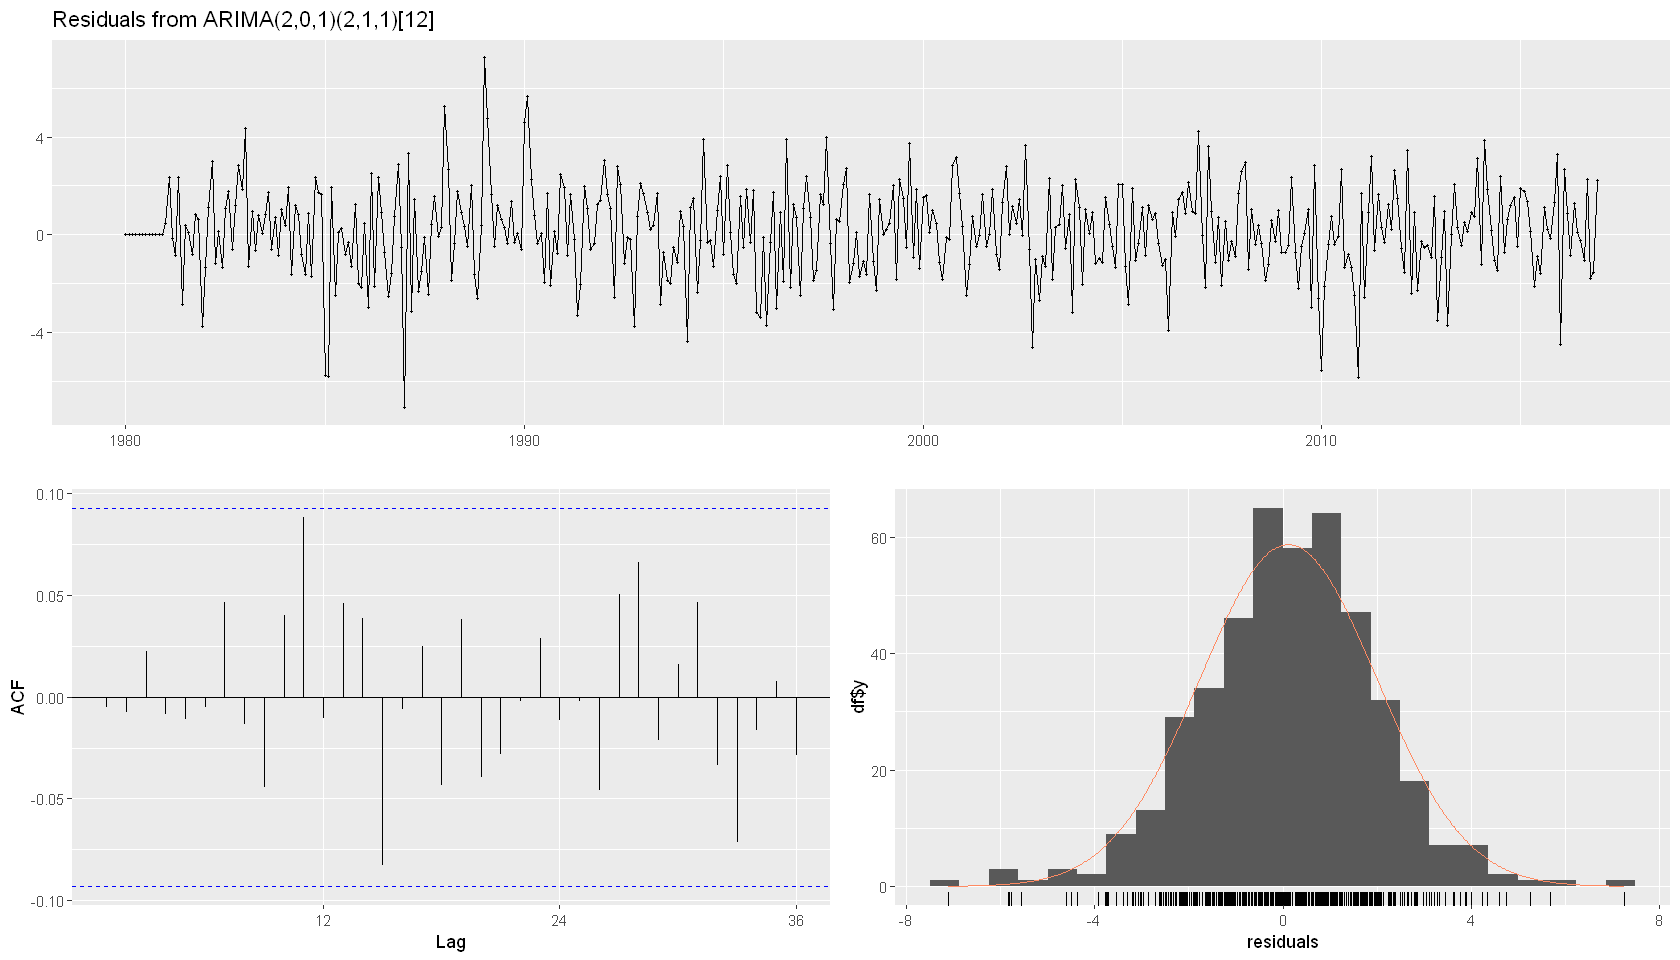

In [51]:
mdl <- arima(train, order = c(2, 0, 1), seasonal=list(order=c(2,1,1)))
checkresiduals(mdl)

In [52]:
Box.test(mdl$residuals)


	Box-Pierce test

data:  mdl$residuals
X-squared = 0.010828, df = 1, p-value = 0.9171



	Shapiro-Wilk normality test

data:  mdl$residuals
W = 0.99078, p-value = 0.007114


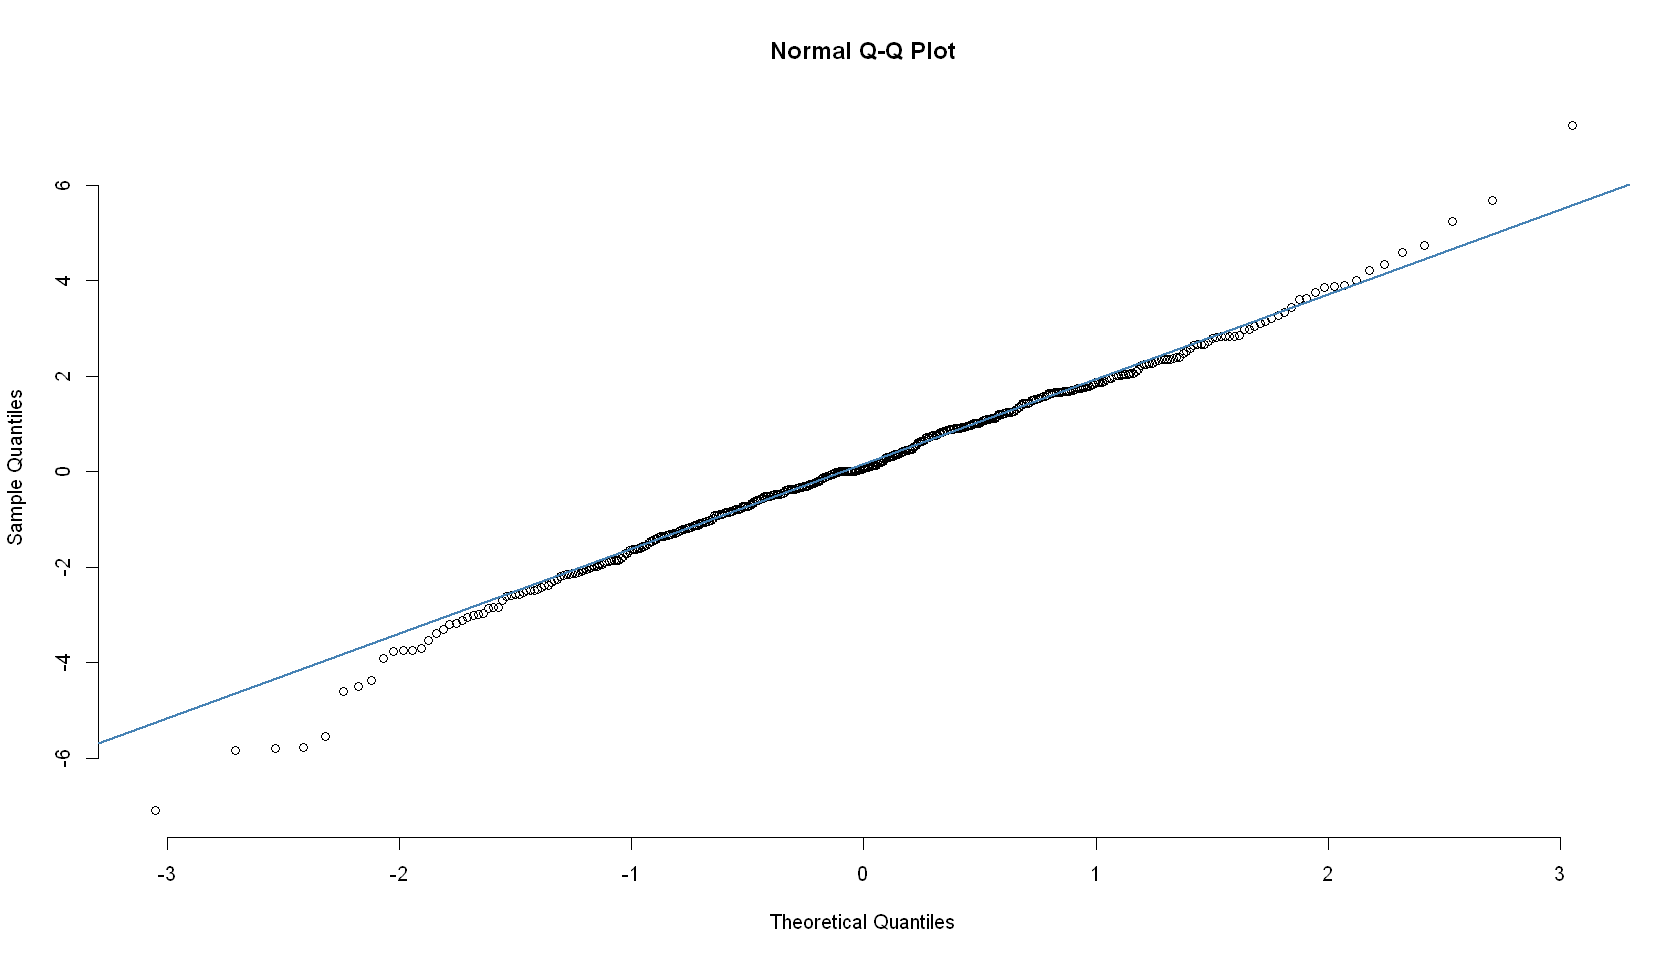

In [53]:
qqnorm(mdl$residuals, pch=1, frame=FALSE)
qqline(mdl$residuals, col="steelblue", lwd=2)
shapiro.test(mdl$residuals)

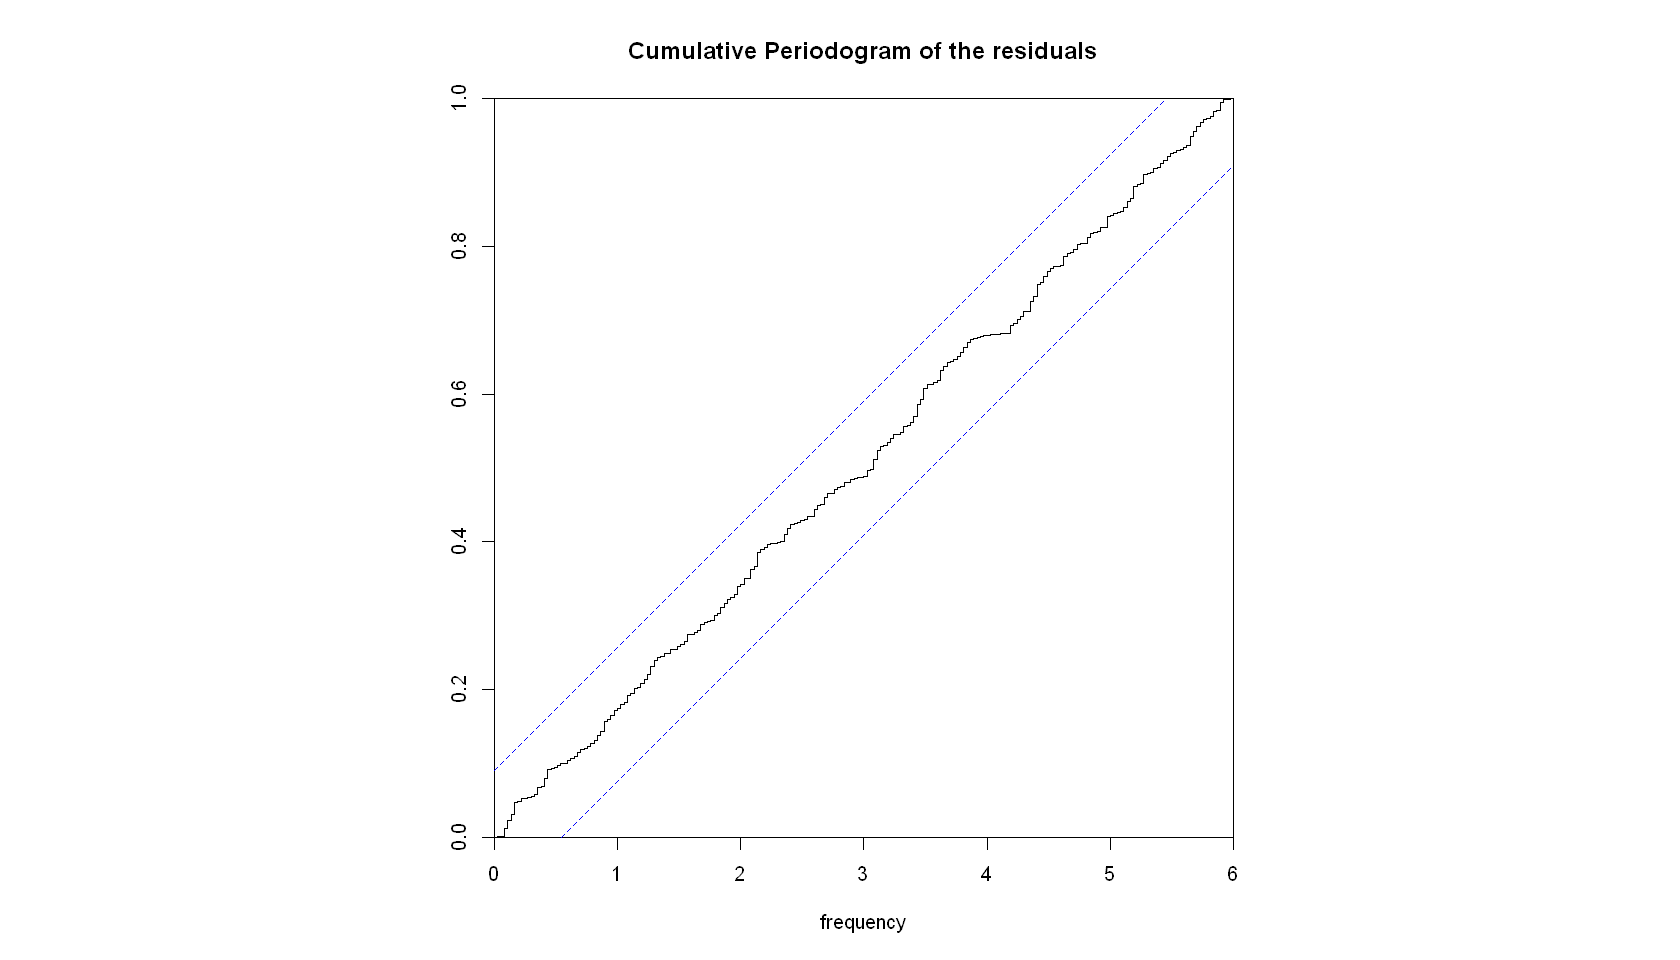

In [54]:
cpgram(mdl$residuals, main="Cumulative Periodogram of the residuals")

# Forecasting

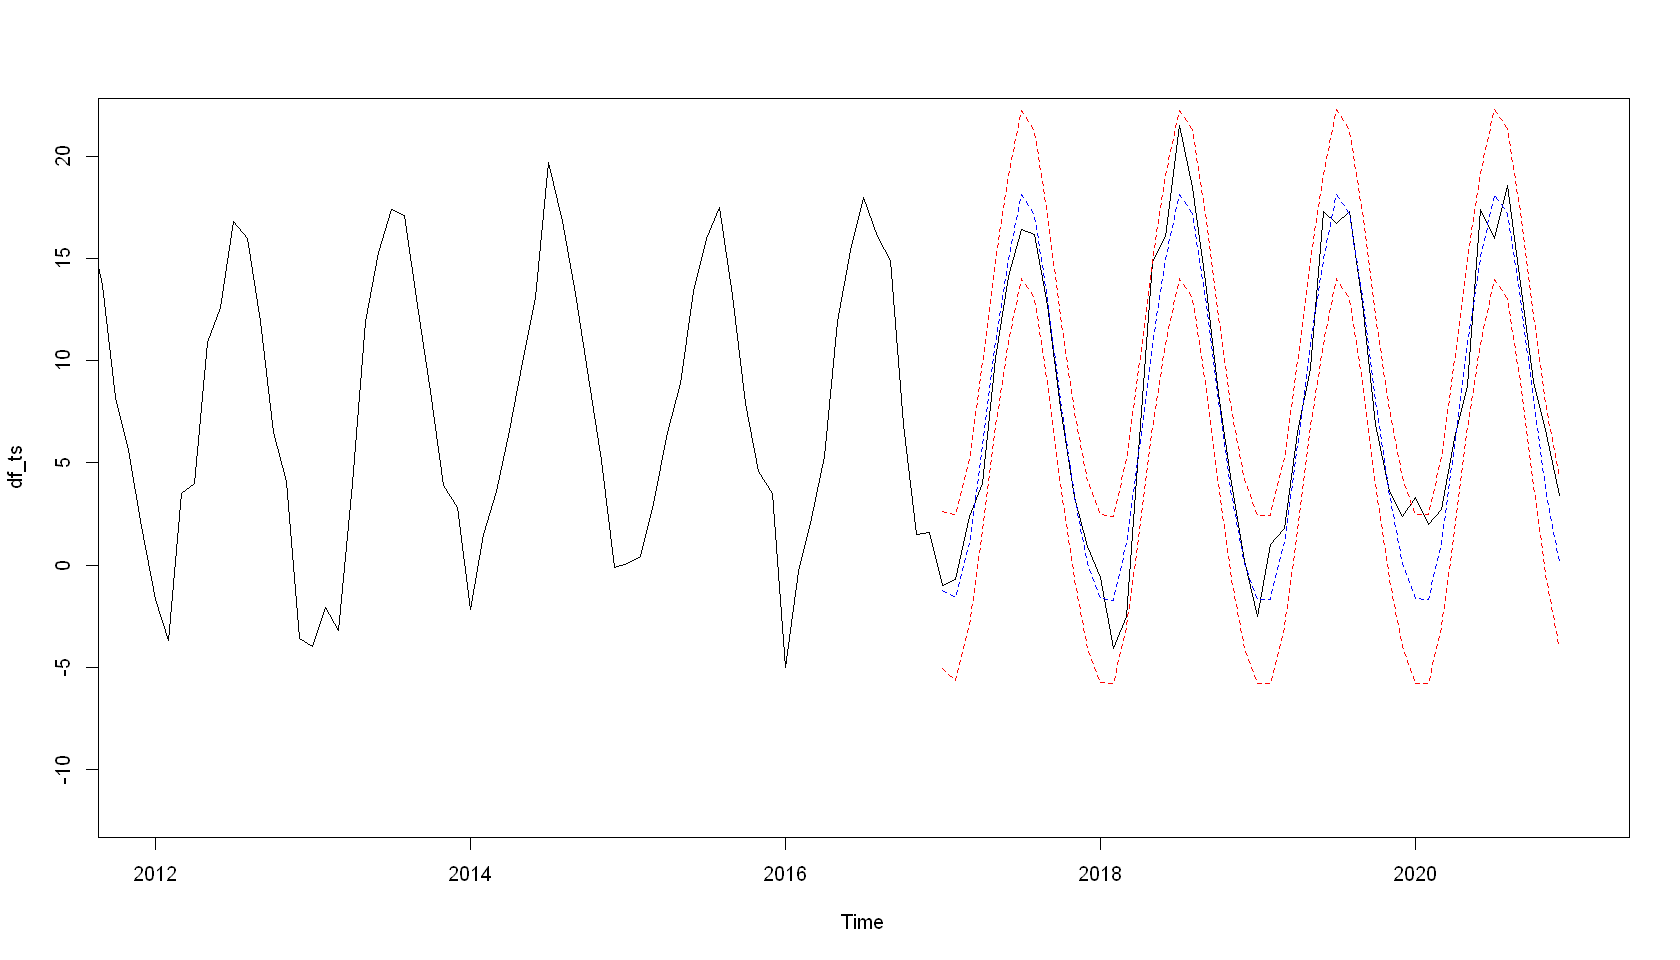

In [60]:
# Forecasting

mdl <- arima(train, order = c(2, 0, 1), seasonal=list(order=c(2,1,1)))
pred <- predict(mdl, n.ahead=48)
ts.plot(df_ts, xlim= c(2012, 2021))

points(pred$pred, type="l", col="blue", lty=2)
lines(pred$pred+2*pred$se, col="red", lty=2)
lines(pred$pred-2*pred$se, col="red", lty=2)

In [56]:
mdl

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"



Call:
arima(x = train, order = c(2, 0, 1), seasonal = list(order = c(2, 1, 1)))

Coefficients:
         ar1      ar2      ma1     sar1     sar2     sma1
      1.3179  -0.3184  -0.9794  -0.0055  -0.0115  -0.9814
s.e.  0.0298   0.0298   0.0167   0.0375      NaN   0.0312

sigma^2 estimated as 3.645:  log likelihood = -909.68,  aic = 1833.36